# K-mer library

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import subprocess
from scipy.stats import ttest_rel,wilcoxon,ranksums,ttest_ind
from statsmodels.stats.multitest import multipletests
import sys
sys.path.append("../code")
from analysis_utils import *
import shlex
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score,mean_squared_error
import pickle

In [5]:
df = pd.read_table('../data/KMAC-DeepAccess-library.csv')
norm = df.copy()
for i in range(1,5):
    for j in range(1,3):
        norm['dpnii.es'+str(i)+'.'+str(j)] = norm['dpnii.es'+str(i)+'.'+str(j)]/np.sum(norm['dpnii.es'+str(i)+'.'+str(j)]/1000000)
        norm['dpni.es'+str(i)+'.'+str(j)] = norm['dpni.es'+str(i)+'.'+str(j)]/np.sum(norm['dpni.es'+str(i)+'.'+str(j)]/1000000)
        norm['es'+str(i)+'.'+str(j)] = norm['dpnii.es'+str(i)+'.'+str(j)]/(norm['dpnii.es'+str(i)+'.'+str(j)] + norm['dpni.es'+str(i)+'.'+str(j)])
for i in range(1,3):
    for j in range(1,3):
        norm['dpnii.ed'+str(i)+'.'+str(j)] = norm['dpnii.ed'+str(i)+'.'+str(j)]/np.sum(norm['dpnii.ed'+str(i)+'.'+str(j)]/1000000)
        norm['dpni.ed'+str(i)+'.'+str(j)] = norm['dpni.ed'+str(i)+'.'+str(j)]/np.sum(norm['dpni.ed'+str(i)+'.'+str(j)]/1000000)
        norm['ed'+str(i)+'.'+str(j)] = norm['dpnii.ed'+str(i)+'.'+str(j)]/(norm['dpnii.ed'+str(i)+'.'+str(j)] + norm['dpni.ed'+str(i)+'.'+str(j)])

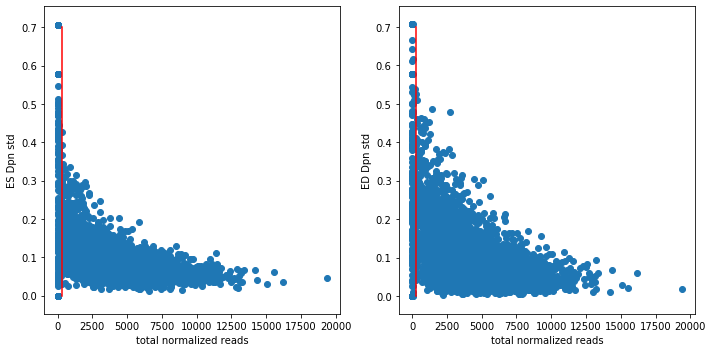

In [6]:
norm['total normalized reads'] = norm[[c for c in norm.columns if 'dpni' in c or 'dpnii' in c]].sum(axis=1)
norm['ES Dpn std'] = norm[[c for c in norm.columns if c[:2] == 'es']].std(axis=1)
norm['ED Dpn std'] = norm[[c for c in norm.columns if c[:2] == 'ed']].std(axis=1)

plt.figure(figsize=(10,5))
norm['total normalized reads'] = norm[[c for c in norm.columns if 'dpni' in c or 'dpnii' in c]].sum(axis=1)
plt.subplot(1,2,1)
plt.scatter(x='total normalized reads',y='ES Dpn std',data=norm)
plt.plot([300,300],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ES Dpn std')
plt.tight_layout()
plt.subplot(1,2,2)
norm['total_reads'] = norm[[c for c in norm.columns if 'dpni' in c or 'dpnii' in c]].sum(axis=1)
plt.scatter(x='total normalized reads',y='ED Dpn std',data=norm)
plt.plot([300,300],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ED Dpn std')
plt.tight_layout()
plt.show()

In [7]:
norm = norm[norm['total normalized reads'] > 300]
norm.dropna(inplace=True)

In [8]:
norm['ED Dpn ratio'] = (norm['ed1.1']+norm['ed1.2']+norm['ed2.1']+norm['ed2.2'])/4.0
norm['ES Dpn ratio'] = (norm['es1.1']+norm['es1.2']+norm['es2.1']+norm['es2.2']+norm['es3.1']+norm['es3.2']+norm['es4.1']+norm['es4.2'])/8.0

In [9]:
norm['catdesc'] =[cat2desc[c.strip('S')] for c in norm['category']]
norm['kmer'] = [get_kmer(d) for d  in norm['description']]
norm['control'] = [get_type(c) for c in norm['category']]
norm['background'] = [get_bg(d) for d in norm['description']]

In [10]:
len(norm)

5507

In [11]:
def gc_model(train,test,y):
    X = sm.add_constant(train['gc.content'])
    X_test = sm.add_constant(test['gc.content'])
    gc_glm= sm.GLM(y,X).fit()
    pred = gc_glm.predict(X_test)
    return pred,gc_glm,['offset','GC']

def additive_kmer_model(train,test,y):
    kmers = set([k for k in train['kmer'] if '-' not in k])
    train_gc = np.array(train['gc.content']).reshape((-1,1))
    train_kmer_mat = np.zeros((train_gc.shape[0],len(kmers)))
    for ki,kmer in enumerate(kmers):
        for j,seq in enumerate(list(train.seq)):
            train_kmer_mat[j,ki] = min(seq.count(kmer),1)
    X = sm.add_constant(np.concatenate([train_gc,train_kmer_mat],axis=1))
    
    test_gc = np.array(test['gc.content']).reshape((-1,1))
    test_kmer_mat = np.zeros((test_gc.shape[0],len(kmers)))
    for ki,kmer in enumerate(kmers):
        for j,seq in enumerate(list(test.seq)):
            test_kmer_mat[j,ki] = min(seq.count(kmer),1)
    X_test = sm.add_constant(np.concatenate([test_gc,test_kmer_mat],axis=1))
    glm= sm.GLM(y,X).fit()
    pred = glm.predict(X_test)
    return pred,glm,['offset','GC']+list(kmers)

def conditional_kmer_model(train,test,y):
    kmers = set([k for k in train['kmer']])
    train_gc = np.array(train['gc.content']).reshape((-1,1))
    train_kmer_mat = np.zeros((train_gc.shape[0],len(kmers)))
    for ki,kmer in enumerate(kmers):
        train_kmer_mat[:,ki] = (train['kmer'] == kmer)*(train['control'] == 'motif')
    X = sm.add_constant(np.concatenate([train_gc,train_kmer_mat],axis=1))
    test_gc = np.array(test['gc.content']).reshape((-1,1))
    test_kmer_mat = np.zeros((test_gc.shape[0],len(kmers)))
    for ki,kmer in enumerate(kmers):
        test_kmer_mat[:,ki] = (test['kmer'] == kmer)*(test['control'] == 'motif')
    X_test = sm.add_constant(np.concatenate([test_gc,test_kmer_mat],axis=1))
    glm= sm.GLM(y,X).fit()
    pred = glm.predict(X_test)
    return pred,glm,['offset','GC']+list(kmers)

In [12]:
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score,mean_squared_error
train_norm = norm[norm['catdesc'].isin([cat2desc['CAT'+str(i)] for i in range(9,16) if i != 11 and i != 14])]

In [13]:
set(train_norm['catdesc'])

{'ED-Salient-TF',
 'ED-Salient-Top',
 'ES-Salient-TF',
 'ES-Salient-Top',
 'SLOT-CNN'}

In [14]:
train_norm['ed.average'] = train_norm['ED Dpn ratio']
train_norm['es.average'] = train_norm['ES Dpn ratio']
bgs = list(set(train_norm.background))
adddict = {'name':[],'value':[],'celltype':[]}
conddict = {'name':[],'value':[],'celltype':[]}
explained_variance = {'model':[],'eval':[],'es_eval':[],'ed_eval':[],'k':[]}
kmer_ev = {'kmer':[],'model':[],'eval':[],'rep':[]}
print(len(bgs))
for k in range(8):
    bgkeep = np.random.choice(bgs,16,replace=False)
    train_set = train_norm[train_norm['background'].isin(bgkeep)]
    test_set = train_norm[~train_norm['background'].isin(bgkeep)]
    print(k,'train n=',len(train_set),'test n=',len(test_set))
    gc_pred_ed,gc_glm,_ = gc_model(train_set,test_set,train_set['ed.average'])
    additive_pred_ed,additive_glm,additive_vars = additive_kmer_model(train_set,test_set,
                                                                   train_set['ed.average'])
    
    multiplicative_pred_ed,multiplicative_glm,multiplicative_vars = additive_kmer_model(train_set,test_set,
                                                                   np.log(train_set['ed.average']))
    conditional_pred_ed,conditional_glm,conditional_vars = conditional_kmer_model(train_set,test_set,
                                                                   train_set['ed.average'])
 
    adddict['name'].extend(additive_vars)
    adddict['celltype'].extend(['endoderm' for _ in range(len(additive_vars))])
    adddict['value'].extend(additive_glm.params)
    conddict['name'].extend(conditional_vars)
    conddict['celltype'].extend(['endoderm' for _ in range(len(conditional_vars))])
    conddict['value'].extend(conditional_glm.params)
    
    gc_pred_es,gc_glm,_ = gc_model(train_set,test_set,train_set['es.average'])
    additive_pred_es,additive_glm,additive_vars = additive_kmer_model(train_set,test_set,
                                                                   train_set['es.average'])
    multiplicative_pred_es,multiplicative_glm,multiplicative_vars = additive_kmer_model(train_set,test_set,
                                                                   np.log(train_set['es.average']))
    conditional_pred_es,conditional_glm,conditional_vars = conditional_kmer_model(train_set,test_set,
                                                                   train_set['es.average'])
    explained_variance['model'].extend(['GC','additive','multiplicative','conditional'])
    explained_variance['eval'].extend([explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (gc_pred_ed-gc_pred_es)),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (additive_pred_ed-additive_pred_es)),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (np.exp(multiplicative_pred_ed) - np.exp(multiplicative_pred_es))),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (conditional_pred_ed-conditional_pred_es))])
                                       
    explained_variance['es_eval'].extend([explained_variance_score((test_set['es.average']),
                                        (gc_pred_es)),
                              explained_variance_score((test_set['es.average']),
                                        (additive_pred_es)),
                              explained_variance_score((test_set['es.average']),
                                        np.exp(multiplicative_pred_es)),
                              explained_variance_score((test_set['es.average']),
                                        (conditional_pred_es))])
    explained_variance['ed_eval'].extend([explained_variance_score((test_set['ed.average']),
                                        (gc_pred_ed)),
                              explained_variance_score((test_set['ed.average']),
                                        (additive_pred_ed)),
                              explained_variance_score((test_set['ed.average']),
                                        np.exp(multiplicative_pred_ed)),
                              explained_variance_score((test_set['ed.average']),
                                        (conditional_pred_ed))])
    explained_variance['k'].extend([k for _ in range(4)])

/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and wil

24
0 train n= 2325 test n= 1205


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


1 train n= 2324 test n= 1206


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


2 train n= 2405 test n= 1125


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


3 train n= 2326 test n= 1204


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


4 train n= 2400 test n= 1130


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


5 train n= 2408 test n= 1122


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


6 train n= 2327 test n= 1203


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


7 train n= 2327 test n= 1203


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


0.005859342799884314 0.9941406572001157 0.005859342799884314
0.005859342799884314 0.16349467479900753 0.005859342799884314
0.005859342799884314 0.9941406572001157 0.005859342799884314


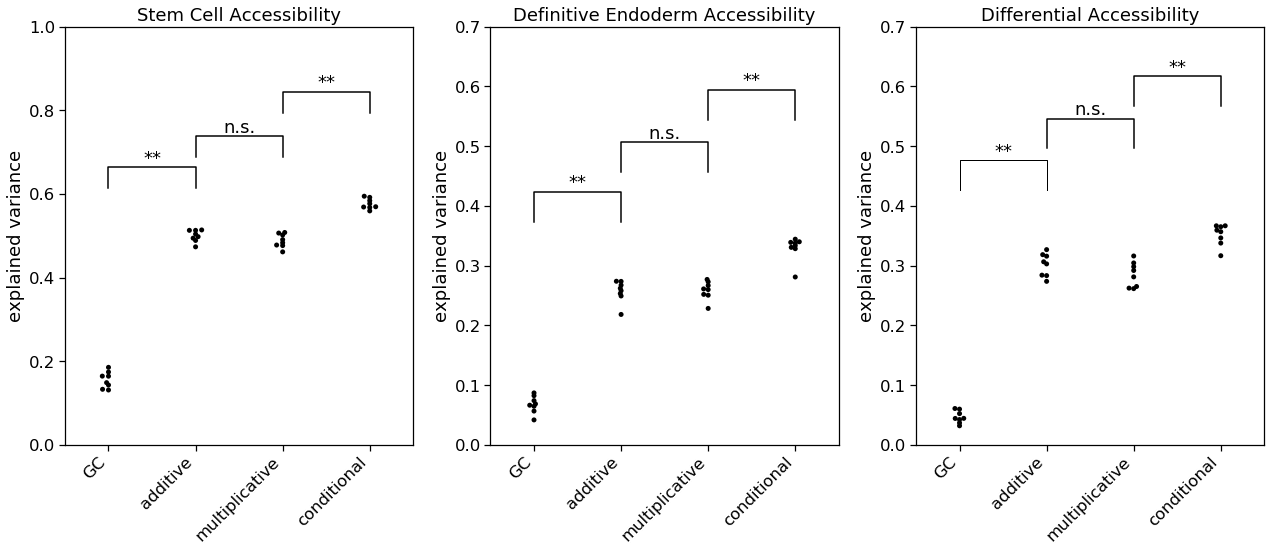

In [15]:
evaldf = pd.DataFrame(explained_variance)

sns.set_context('notebook',font_scale=1.5)
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
g = sns.swarmplot(x='model',y='es_eval',data=evaldf,color='black')
plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['es_eval'])
test1 = wilcoxon(eval_pivot['es_eval'].conditional,eval_pivot['es_eval'].multiplicative,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['es_eval'].multiplicative,eval_pivot['es_eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['es_eval'].additive,eval_pivot['es_eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 2,3
y, h, col = eval_pivot['es_eval'].conditional.max() + dist2, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['es_eval'].multiplicative.max() + 0.18, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['es_eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,1.0])

plt.title('Stem Cell Accessibility')
plt.tight_layout()

plt.subplot(1,3,2)
g = sns.swarmplot(x='model',y='ed_eval',data=evaldf,color='black')
plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
plt.xlabel('')
eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['ed_eval'])
test1 = wilcoxon(eval_pivot['ed_eval'].conditional,eval_pivot['ed_eval'].multiplicative,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['ed_eval'].multiplicative,eval_pivot['ed_eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['ed_eval'].additive,eval_pivot['ed_eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 2,3
y, h, col = eval_pivot['ed_eval'].conditional.max() + dist2, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['ed_eval'].multiplicative.max() + 0.18, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['ed_eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,0.7])


plt.title('Definitive Endoderm Accessibility')
plt.subplot(1,3,3)
g = sns.swarmplot(x='model',y='eval',data=evaldf,color='black')
plt.tight_layout()

plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
plt.xlabel('')

eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['eval'])
test1 = wilcoxon(eval_pivot['eval'].conditional,eval_pivot['eval'].multiplicative,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['eval'].multiplicative,eval_pivot['eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['eval'].additive,eval_pivot['eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 2,3
y, h, col = eval_pivot['eval'].conditional.max() + dist2, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['eval'].multiplicative.max() + 0.18, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,0.7])

plt.title('Differential Accessibility')
plt.tight_layout()
plt.savefig('plots/compare_regression_models_accessibility.svg')

# Consensus TF library

In [27]:
df = pd.read_table('../data/Pioneer_TF_library.csv')

In [28]:
expts = ['rarrxr1_slotv4_endoderm_rep1a',
         'rarrxr1_slotv4_endoderm_rep1b',
         'rarrxr1_slotv4_endoderm_rep2a',
         'rarrxr1_slotv4_endoderm_rep2b',
         'rarrxr1_slotv4_mesc_repa',
         'rarrxr1_slotv4_mesc_repb']
for expt in expts:
    df[expt+'_dpnii_norm'] = df[expt+'_dpnii']/(np.sum(df[expt+'_dpnii'])/1000000)
    df[expt+'_dpni_norm'] = df[expt+'_dpni']/(np.sum(df[expt+'_dpni'])/1000000)
    df[expt+' Dpn Ratio'] = df[expt+'_dpnii_norm']/(df[expt+'_dpnii_norm']+df[expt+'_dpni_norm'])
df['ES Dpn ratio'] = (df['rarrxr1_slotv4_mesc_repa Dpn Ratio'] +df['rarrxr1_slotv4_mesc_repb Dpn Ratio'])/ 2.0
df['ED Dpn ratio'] = (df['rarrxr1_slotv4_endoderm_rep1a Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep1b Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep2a Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep2b Dpn Ratio'])/ 4.0

In [29]:
df['total normalized reads'] = df[[c for c in df.columns if 'dpni_norm' in c or 'dpnii_norm' in c]].sum(axis=1)
df['ES Dpn std'] = df[[c for c in df.columns if 'Dpn Ratio' in c and 'mesc' in c]].std(axis=1)
df['ED Dpn std'] = df[[c for c in df.columns if 'Dpn Ratio' in c and 'endoderm' in c]].std(axis=1)

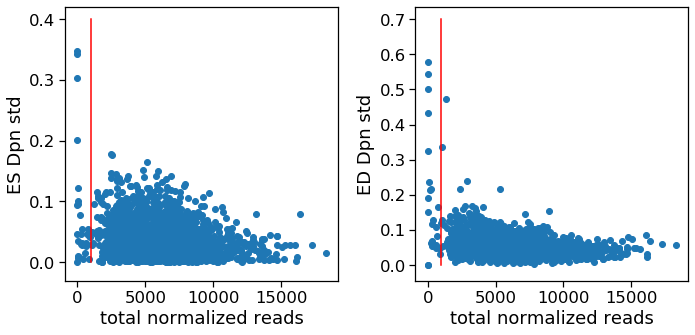

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x='total normalized reads',y='ES Dpn std',data=df)
plt.plot([1000,1000],[0.0,0.4],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ES Dpn std')
plt.tight_layout()
plt.subplot(1,2,2)
plt.scatter(x='total normalized reads',y='ED Dpn std',data=df)
plt.plot([1000,1000],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ED Dpn std')
plt.tight_layout()
plt.show()

In [31]:
df = df[df['total normalized reads'] > 1000]
df['distance'] = df['distance'].astype(str)

In [34]:
keep = df[df['tf'].isin([c for c in set(df['tf']) 
                                      if (('oct4' in c) or ('sox2' in c) or ('klf4' in c)
                                         or ('sox17' in c) or ('gata4' in c) or ('foxa2' in c))])]

In [35]:
all_cats = set(keep['tf'])
tf_singles = list(set([k for k in all_cats if len(k.split(',')) == 1]))
tf_singles

['sox2', 'sox17', 'klf4', 'foxa2', 'oct4', 'gata4']

In [49]:
def gc_model(train,test,y,glm=None):
    X = sm.add_constant(train['gc.content'])
    X_test = sm.add_constant(test['gc.content'])   
    if glm == None:
        glm= sm.OLS(y,X).fit()
    pred = glm.predict(X_test)
    return pred,glm,['offset','GC']

def count_tfs(cat,tf):
    if tf in cat:
        return cat.count(tf)
    else:
        return 0
            
def additive_kmer_model(train,test,y,glm=None):
    tfs = tf_singles
    train_gc = np.array(train['gc.content']).reshape((-1,1))
    train_kmer_mat = np.zeros((train_gc.shape[0],len(tfs)))
    for ki,tf in enumerate(tfs):
        for j,cat in enumerate(list(train.tf)):
            if train.iloc[j]['control'] == 'motif':
                train_kmer_mat[j,ki] = count_tfs(cat,tf)
    X = sm.add_constant(np.concatenate([train_gc,train_kmer_mat],axis=1))
    
    test_gc = np.array(test['gc.content']).reshape((-1,1))
    test_kmer_mat = np.zeros((test_gc.shape[0],len(tfs)))
    for ki,tf in enumerate(tfs):
        for j,cat in enumerate(list(test.tf)):
            if test.iloc[j]['control'] == 'motif':
                test_kmer_mat[j,ki] = count_tfs(cat,tf)
    X_test = sm.add_constant(np.concatenate([test_gc,test_kmer_mat],axis=1))
    if glm == None:
        glm= sm.OLS(y,X).fit()
    pred = glm.predict(X_test)
    return pred,glm,['offset','GC']+list(tfs)

def conditional_kmer_model(train,test,y,glm=None):
    tfs = tf_singles + tf_combos 
    train_gc = np.array(train['gc.content']).reshape((-1,1))
    train_kmer_mat = np.zeros((train_gc.shape[0],len(tfs)))
    for ki,tf in enumerate(tfs):
        train_kmer_mat[:,ki] = (train['tf'] == tf)*(train['control'] == 'motif')
    X = sm.add_constant(np.concatenate([train_gc,train_kmer_mat],axis=1))
    
    test_gc = np.array(test['gc.content']).reshape((-1,1))
    test_kmer_mat = np.zeros((test_gc.shape[0],len(tfs)))
    
    for ki,tf in enumerate(tfs):
        test_kmer_mat[:,ki] = (test['tf'] == tf)*(test['control'] == 'motif')
    X_test = sm.add_constant(np.concatenate([test_gc,test_kmer_mat],axis=1))
    if glm == None:
        glm= sm.OLS(y,X).fit()
    pred = glm.predict(X_test)
    return pred,glm,['offset','GC']+tfs

/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

0 train n= 685 test n= 356


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


1 train n= 695 test n= 346


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


2 train n= 686 test n= 355


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


3 train n= 694 test n= 347


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


4 train n= 695 test n= 346


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


5 train n= 690 test n= 351


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


6 train n= 690 test n= 351


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


7 train n= 702 test n= 339


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


8 train n= 696 test n= 345


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


9 train n= 694 test n= 347


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


10 train n= 700 test n= 341


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


11 train n= 690 test n= 351


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


12 train n= 694 test n= 347


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


13 train n= 697 test n= 344


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


14 train n= 692 test n= 349


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


15 train n= 692 test n= 349


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


16 train n= 693 test n= 348


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


17 train n= 695 test n= 346


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


18 train n= 703 test n= 338


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


19 train n= 689 test n= 352


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


20 train n= 692 test n= 349


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


21 train n= 696 test n= 345


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


22 train n= 694 test n= 347


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


23 train n= 696 test n= 345


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


24 train n= 701 test n= 340


/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


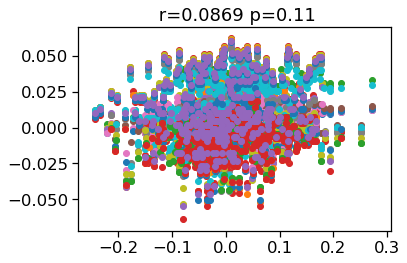

In [50]:
with open('/data/gl/g1/jhammelm/projects/SLOT/libraryv3_analysis/background_random_sample_pioneer_nonlinear_analysis.pkl','rb') as f:
    #sampled bgs generated from np.random.choice and saved so subsequent analysis
    #remains consistent
    sampled_bgs = pickle.load(f)
    
tf_combos = [c for c in all_cats if (len(c.split(','))==2)
            and (('oct4' in c) or ('sox2' in c) or ('klf4' in c))]
tf_combos.extend([c for c in all_cats if (len(c.split(','))==3)
            and (('oct4' in c) or ('sox2' in c) or ('klf4' in c))])
tf_combos.extend([c for c in all_cats if (len(c.split(','))==2)
            and (('foxa2' in c) or ('sox17' in c) or ('gata4' in c))])
tf_combos.extend([c for c in all_cats if (len(c.split(','))==3)
            and (('foxa2' in c) or ('sox17' in c) or ('gata4' in c))])

keep = df[df['tf'].isin([c for c in set(df['tf']) 
                                      if (('oct4' in c) or ('sox2' in c) or ('klf4' in c)
                                         or ('sox17' in c) or ('gata4' in c) or ('foxa2' in c))])]
keep['gc.content'] = [(s.count('G')+s.count('C'))/float(len(s)) for s in keep.seq]
keep['nmotifs'] = [len(c.split(',')) for c in keep['tf']]
keep['nunique'] = [len(set(c.split(','))) for c in keep['tf']]
keep['ed.average'] = keep['ED Dpn ratio']
keep['es.average'] = keep['ES Dpn ratio']

train_norm = keep
bgs = list(set(train_norm.background))
explained_variance = {'model':[],'eval':[],'es_eval':[],'ed_eval':[],'k':[]}
kmer_ev = {'tfset':[],'model':[],'eval':[],'es_eval':[],'ed_eval':[],'rep':[]}
saved_models = {'ESC':[],'DE':[]}
#sampled_bgs=[]
for k in range(25):
    #bgkeep = np.random.choice(bgs,6,replace=False)
    #sampled_bgs.append(bgkeep)
    bgkeep = sampled_bgs[k]
    train_set = train_norm[train_norm['background'].isin(bgkeep)]
    test_set = train_norm[~train_norm['background'].isin(bgkeep)]
    print(k,'train n=',len(train_set),'test n=',len(test_set))
    gc_pred_ed,gc_glm,_ = gc_model(train_set,test_set,train_set['ed.average'])
    additive_pred_ed,additive_glm,additive_vars = additive_kmer_model(train_set,test_set,
                                                                   train_set['ed.average'])
    
    multiplicative_pred_ed,multiplicative_glm,multiplicative_vars = additive_kmer_model(train_set,test_set,
                                                                   np.log10(train_set['ed.average']))
    conditional_pred_ed,conditional_glm,conditional_vars = conditional_kmer_model(train_set,test_set,
                                                                   train_set['ed.average'])
    saved_models['DE'].append({'additive':additive_glm,
                                'GC':gc_glm,
                                'conditional':conditional_glm,
                                'multiplicative':multiplicative_glm})
    
    gc_pred_es,gc_glm,_ = gc_model(train_set,test_set,train_set['es.average'])
    additive_pred_es,additive_glm,additive_vars = additive_kmer_model(train_set,test_set,
                                                                   train_set['es.average'])
    multiplicative_pred_es,multiplicative_glm,multiplicative_vars = additive_kmer_model(train_set,test_set,
                                                                   np.log10(train_set['es.average']))
    conditional_pred_es,conditional_glm,conditional_vars = conditional_kmer_model(train_set,test_set,
                                                                   train_set['es.average'])
    saved_models['ESC'].append({'additive':additive_glm,
                                'GC':gc_glm,
                                'conditional':conditional_glm,
                                'multiplicative':multiplicative_glm})
    explained_variance['model'].extend(['GC','additive','multiplicative','conditional'])
    explained_variance['eval'].extend([explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (gc_pred_ed-gc_pred_es)),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (additive_pred_ed-additive_pred_es)),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        10**multiplicative_pred_ed - 10**multiplicative_pred_es),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (conditional_pred_ed-conditional_pred_es))])
    explained_variance['es_eval'].extend([explained_variance_score((test_set['es.average']),
                                        (gc_pred_es)),
                              explained_variance_score((test_set['es.average']),
                                        (additive_pred_es)),
                              explained_variance_score((test_set['es.average']),
                                        10**multiplicative_pred_es),
                              explained_variance_score((test_set['es.average']),
                                        (conditional_pred_es))])
    explained_variance['ed_eval'].extend([explained_variance_score((test_set['ed.average']),
                                        (gc_pred_ed)),
                              explained_variance_score((test_set['ed.average']),
                                        (additive_pred_ed)),
                              explained_variance_score((test_set['ed.average']),
                                        10**multiplicative_pred_ed),
                              explained_variance_score((test_set['ed.average']),
                                        (conditional_pred_ed))])
    
    plot_scatter((test_set['ed.average']-test_set['es.average']),
                                        (gc_pred_ed-gc_pred_es))
    explained_variance['k'].extend([k for _ in range(4)])
    for tfset in all_cats:
        test_set_kmer = test_set[(test_set['tf'] == tfset) & (test_set['control'] == 'motif')]
        kmer_mask = (test_set['tf'] == tfset) & (test_set['control'] == 'motif')
        if np.sum(kmer_mask) == 0:
            continue
        kmer_ev['tfset'].extend([tfset,tfset,tfset,tfset])
        kmer_ev['model'].extend(['GC','additive','multiplicative','conditional'])
        kmer_ev['eval'].extend([mean_squared_error((test_set_kmer['ed.average']-test_set_kmer['es.average']),
                                        (gc_pred_ed[kmer_mask]-gc_pred_es[kmer_mask])),
                              mean_squared_error((test_set_kmer['ed.average']-test_set_kmer['es.average']),
                                        (additive_pred_ed[kmer_mask]-additive_pred_es[kmer_mask])),
                              mean_squared_error((test_set_kmer['ed.average']-test_set_kmer['es.average']),
                                        10**multiplicative_pred_ed[kmer_mask] - 10**multiplicative_pred_es[kmer_mask]),
                              mean_squared_error((test_set_kmer['ed.average']-test_set_kmer['es.average']),
                                        (conditional_pred_ed[kmer_mask]-conditional_pred_es[kmer_mask]))])
        kmer_ev['es_eval'].extend([mean_squared_error(test_set_kmer['es.average'],
                                        gc_pred_es[kmer_mask]),
                              mean_squared_error(test_set_kmer['es.average'],
                                        additive_pred_es[kmer_mask]),
                              mean_squared_error((test_set_kmer['es.average']),
                                                 10**multiplicative_pred_es[kmer_mask]),
                              mean_squared_error(test_set_kmer['es.average'],
                                        conditional_pred_es[kmer_mask])])
        kmer_ev['ed_eval'].extend([mean_squared_error(test_set_kmer['ed.average'],
                                        gc_pred_ed[kmer_mask]),
                              mean_squared_error(test_set_kmer['ed.average'],
                                        additive_pred_ed[kmer_mask]),
                              mean_squared_error((test_set_kmer['ed.average']),
                                                10**multiplicative_pred_ed[kmer_mask]),
                              mean_squared_error(test_set_kmer['ed.average'],
                                        conditional_pred_ed[kmer_mask])])
        
        kmer_ev['rep'].extend([k,k,k,k])

0.8994196783399859 0.9999548890863583 6.128468010809964e-06
0.7784447059652801 0.5588318151271443 6.128468010809964e-06
0.9956520044046652 0.9999938715319892 2.560443548752839e-05


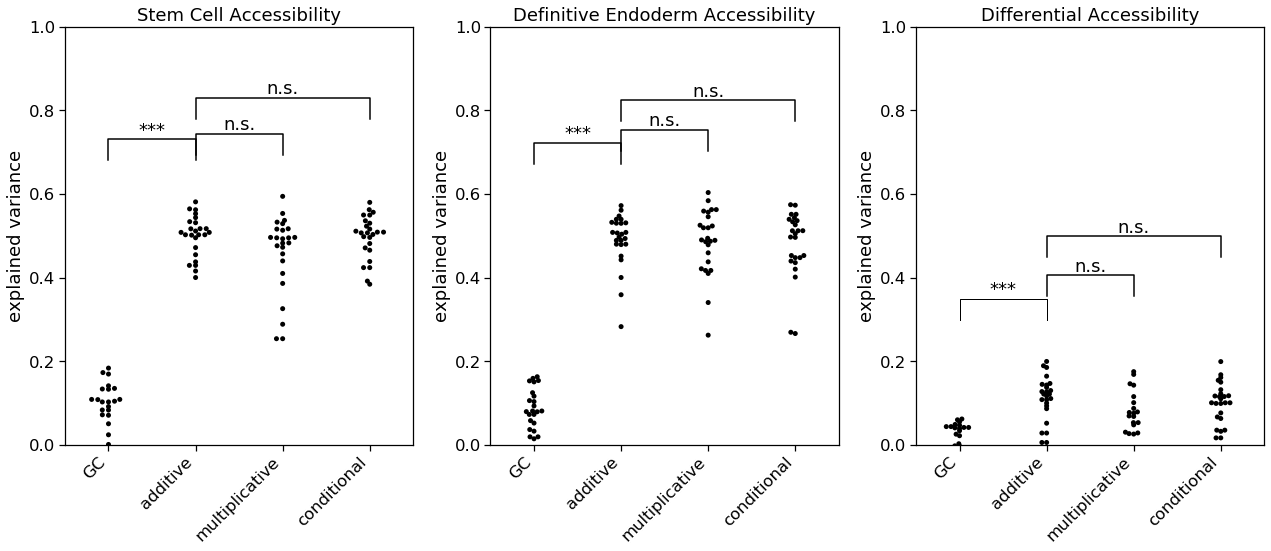

In [51]:
evaldf = pd.DataFrame(explained_variance)

sns.set_context('notebook',font_scale=1.5)
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
g = sns.swarmplot(x='model',y='es_eval',data=evaldf,color='black')
plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['es_eval'])
test1 = wilcoxon(eval_pivot['es_eval'].conditional,eval_pivot['es_eval'].additive,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['es_eval'].multiplicative,eval_pivot['es_eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['es_eval'].additive,eval_pivot['es_eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 1,3
y, h, col = eval_pivot['es_eval'].conditional.max() + 0.2, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['es_eval'].multiplicative.max() + 0.10, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['es_eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,1.0])

plt.title('Stem Cell Accessibility')
plt.tight_layout()

plt.subplot(1,3,2)
g = sns.swarmplot(x='model',y='ed_eval',data=evaldf,color='black')
plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
plt.xlabel('')
eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['ed_eval'])
test1 = wilcoxon(eval_pivot['ed_eval'].conditional,eval_pivot['ed_eval'].additive,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['ed_eval'].multiplicative,eval_pivot['ed_eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['ed_eval'].additive,eval_pivot['ed_eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 1,3
y, h, col = eval_pivot['ed_eval'].conditional.max() + 0.2, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['ed_eval'].multiplicative.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['ed_eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,1.0])


plt.title('Definitive Endoderm Accessibility')
plt.subplot(1,3,3)
g = sns.swarmplot(x='model',y='eval',data=evaldf,color='black')
plt.tight_layout()

plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
plt.xlabel('')

eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['eval'])
test1 = wilcoxon(eval_pivot['eval'].conditional,eval_pivot['eval'].additive,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['eval'].multiplicative,eval_pivot['eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['eval'].additive,eval_pivot['eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 1,3
y, h, col = eval_pivot['eval'].conditional.max() + dist2+0.05, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['eval'].multiplicative.max() + 0.18, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,1.0])

plt.title('Differential Accessibility')
plt.tight_layout()
plt.savefig('plots/oskfgs-eval-significance.svg',bbox_inches='tight')

In [52]:
kmer_conditional_data = pd.DataFrame(kmer_ev)
plt.figure(figsize=(5,5))
is_significant = {}
best_model_de = {}
test_comparison =  {}
pvals = {}
for tfset in tf_combos:
    tmp = kmer_conditional_data[kmer_conditional_data['tfset']==tfset]
    tmppv = tmp.pivot_table(index='rep',columns='model',values='ed_eval')
    best_model = 'additive'
    for model in ['multiplicative','conditional']:
        test = wilcoxon(tmppv[model],tmppv[best_model],alternative='less')
        if test[1] < (0.05/(2*len(tf_combos))):
            best_model = model
    best_model_de[tfset] = best_model

<Figure size 360x360 with 0 Axes>

In [53]:
kmer_conditional_data = pd.DataFrame(kmer_ev)
plt.figure(figsize=(5,5))
is_significant = {}
best_model_esc = {}
test_comparison =  {}

for tfset in tf_combos:
    tmp = kmer_conditional_data[kmer_conditional_data['tfset']==tfset]
    tmppv = tmp.pivot_table(index='rep',columns='model',values='es_eval')
    best_model = 'additive'
    for model in ['multiplicative','conditional']:
        test = wilcoxon(tmppv[model],tmppv[best_model],alternative='less')
        if test[1] < (0.05/(2*len(tf_combos))):
            best_model = model
    best_model_esc[tfset] = best_model

<Figure size 360x360 with 0 Axes>

In [54]:
kmer_conditional_data = pd.DataFrame(kmer_ev)
plt.figure(figsize=(5,5))
is_significant = {}
best_model_diff= {}
for tfset in tf_combos:
    tmp = kmer_conditional_data[kmer_conditional_data['tfset']==tfset]
    tmppv = tmp.pivot_table(index='rep',columns='model',values='eval')
    best_model='additive'
    for model in ['multiplicative','conditional']:
        test = wilcoxon(tmppv[model],tmppv[best_model],alternative='less')
        if test[1] < (0.05/(2*len(tf_combos))):
            best_model = model
    best_model_diff[tfset] = best_model

<Figure size 360x360 with 0 Axes>

In [58]:
keep = df[df['tf'].isin([c for c in set(df['tf']) 
                                      if (('oct4' in c) or ('sox2' in c) or ('klf4' in c)
                                         or ('sox17' in c) or ('gata4' in c) or ('foxa2' in c))])]

wilcoxon_tests = {}
ttest_tests = {}
all_cats = list(set(keep['tf']))
fc = {}
for cat in all_cats:
    keep_cat = keep[(keep['tf']==cat)&(keep['control']=='motif')]
    keep_pd = keep_cat.pivot_table(index=['background','distance'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    wilcoxon_tests[cat] = wilcoxon(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    ttest_tests[cat] = ttest_rel(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    fc[cat] = np.mean(keep_pd['ES Dpn ratio'])/(np.mean(keep_pd['ED Dpn ratio'])+np.mean(keep_pd['ES Dpn ratio']))
wilcoxon_pvals = np.array([wilcoxon_tests[cat][1] for cat in all_cats])
ttest_pvals = np.array([ttest_tests[cat][1] for cat in all_cats])
wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
diff_sig_cats = [cat for i,cat in enumerate(all_cats) if ttest_true[i] and wilcoxon_true[i]]

/data/gl/g1/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [59]:
scram_wilcoxon_tests = {}
scram_ttest_tests = {}
for cat in diff_sig_cats:
    keep_motif = keep[(keep['tf']==cat)&(keep['control']=='motif')]
    def contains_motifs(df_cat):
        data = cat.split(',')
        for tf in data:
            if tf not in df_cat:
                return False
        return True
    keep_ctrl = keep[keep['tf']==cat]
    keep_ctrl = keep_ctrl[keep_ctrl['control']=='scrambled']
    keep_cat = pd.concat([keep_ctrl,keep_motif])
    keep_pd = keep_cat.pivot_table(index=['background','distance'],columns=['control'],
                                   values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    es_scram = wilcoxon(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = wilcoxon(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    if es_scram[1] < ed_scram[1]:
        scram_wilcoxon_tests[cat] = es_scram
    else:
        scram_wilcoxon_tests[cat] = ed_scram
    es_scram = ttest_rel(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = ttest_rel(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    if es_scram[1] < ed_scram[1]:
        scram_ttest_tests[cat] = es_scram
    else:
        scram_ttest_tests[cat] = ed_scram
wilcoxon_pvals = np.array([scram_wilcoxon_tests[cat][1] for cat in diff_sig_cats])
ttest_pvals = np.array([scram_ttest_tests[cat][1] for cat in diff_sig_cats])

wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
scram_diff_sig_cats = [cat for i,cat in enumerate(diff_sig_cats) if ttest_true[i] and wilcoxon_true[i]]
scram_diff_sig_ordered = sorted(scram_diff_sig_cats,key=lambda x:ttest_tests[x][1])

In [60]:
best_model_eval = pd.DataFrame({'TF-combo':tf_combos,
                               'Best Model ESC':[best_model_esc[tf] for tf in tf_combos],
                               'Best Model DE':[best_model_de[tf] for tf in tf_combos],
                               'Best Model Differential':[best_model_diff[tf] for tf in tf_combos],
                               'Is Differential':[tf in scram_diff_sig_ordered for tf in tf_combos]})
#best_model_eval.to_csv('nonlinear-OSKFG-results.csv')

In [61]:
best_model_eval

,TF-combo,Best Model ESC,Best Model DE,Best Model Differential,Is Differential
0,"oct4,oct4",additive,additive,additive,False
1,"oct4,klf4",additive,additive,additive,True
2,"sox2,oct4",additive,additive,additive,False
3,"sox2,sox2",additive,additive,additive,True
4,"klf4,sox2",additive,multiplicative,additive,True
5,"oct4,sox2",additive,multiplicative,additive,False
6,"klf4,oct4",additive,additive,additive,False
7,"klf4,klf4",additive,additive,additive,True
8,"sox2,klf4",additive,additive,additive,True
9,"oct4,klf4,sox2",additive,additive,additive,True
